<a href="https://colab.research.google.com/github/NatnaelTDaba/Object-Detection/blob/master/xView_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import sys
work_dir = '/content/drive/MyDrive/UCF/CAP7919/Object-Detection/'
data_dir = work_dir+'data/'
util_dir = work_dir+'data_utilities/'
os.chdir(work_dir)
sys.path.append(work_dir+util_dir)
sys.path.append(work_dir+data_dir)

In [4]:
import aug_util as aug
import wv_util as wv
import matplotlib.pyplot as plt
import numpy as np
import csv
%matplotlib inline
from PIL import Image, ImageDraw # to read images
import cv2
from tqdm import tqdm
import pickle

In [11]:
!ls -lhs .

total 356M
4.0K drwx------ 3 root root 4.0K Feb 17 18:59 data
4.0K drwx------ 4 root root 4.0K Feb 17 18:55 data_utilities
 512 -rw------- 1 root root   19 Feb 17 18:50 README.md
157K -rw------- 1 root root 157K Feb 18 20:20 xView_Processing.ipynb
355M -rw------- 1 root root 355M Feb 14  2018 xView_train.geojson


In [7]:
%pwd

'/content/drive/MyDrive/UCF/CAP7919/Object-Detection'

In [9]:
!tar -xf ./data/train_labels.tgz

In [ ]:
#Load an image
chip_name = '../train_images/2523.tif'
arr = wv.get_image(chip_name)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(arr)

In [ ]:
#Loading our labels
coords, chips, classes = wv.get_labels('../xView_train.geojson')

100%|██████████| 601937/601937 [00:03<00:00, 163074.17it/s]


In [ ]:
labels = {}
with open('xview_class_labels.txt') as f:
    for row in csv.reader(f):
        labels[int(row[0].split(":")[0])] = row[0].split(":")[1]

valid_labels = list(labels.keys())

In [ ]:
file_name = "valid_chip_names.pkl"
open_file = open(file_name, "rb")
valid_chip_names = pickle.load(open_file)
open_file.close()

In [ ]:
unique, counts = np.unique(classes, return_counts=True)
class_counts = {k:0 for k in list(unique.astype('int64'))}

In [ ]:
org_data_dir = '../train_images/'
tgt_data_dir = '../new_train_images_2/'
chip_names = list(np.unique(chips))
k = 0

imgs_processed = 0

with tqdm(total=len(chip_names), position=0, leave=True) as pbar:

  for chip_name in tqdm(chip_names, position=0, leave=True):

    if chip_name in valid_chip_names:

      chip = np.array(Image.open(org_data_dir+chip_name))

      chip_bboxes = coords[chips==chip_name]
      bbox_classes = classes[chips==chip_name].astype(np.int64)
      imgs_processed += 1
      for i in range(len(chip_bboxes)):

        cropped_img = chip[int(chip_bboxes[i][1])-10:int(chip_bboxes[i][3])+10, int(chip_bboxes[i][0])-10:int(chip_bboxes[i][2])+10]

        if cropped_img.shape[0] > 0 and cropped_img.shape[1] > 0:

          im = Image.fromarray(cropped_img)
          im.save(tgt_data_dir+str(bbox_classes[i])+'/'+str(k+1)+'.jpg')
          k += 1
          class_counts[bbox_classes[i]] += 1

    pbar.update()

print("\nNumber of extracted images:", k)
print("Number of chips processed:", imgs_processed)

100%|██████████| 847/847 [1:34:35<00:00,  6.70s/it]


Number of extracted images: 593162
Number of chips processed: 846


In [ ]:
new_pixel_areas = []
low_thresh = 6
high_thresh = 10
num_removed_images = 0
with tqdm(total=60, position=0, leave=True) as pbar:
  for subdir, dirs, files in tqdm(os.walk('../new_train_images_2'), position=0, leave=True):
      for filename in files:
        filepath = subdir + os.sep + filename
        if filepath.endswith(".jpg"):
          img = np.array(Image.open(filepath))
          area = img.shape[0]*img.shape[1]
          if (np.log(area) > high_thresh) or (np.log(area) < low_thresh):
            os.remove(filepath)
            num_removed_images+=1
          else:
            new_pixel_areas.append(area)

      pbar.update()

63it [1:27:35, 83.43s/it]
63it [1:27:35, 83.43s/it]


In [ ]:
num_removed_images
num_removed_images_file = open('num_of_removed_images.pkl','wb')
pickle.dump(num_removed_images, num_removed_images_file)
num_removed_images_file.close()

In [ ]:
593162-num_removed_images

581509

In [ ]:
num_removed_images

11653

In [ ]:
!ls

 aug_util.py		     process_wv.py   valid_chip_names.pkl
 LICENSE		     __pycache__     wv_util.py
 new_pixel_areas2.pkl	     README.md	     xview_class_labels.txt
 num_of_removed_images.pkl   tfr_util.py    'xView Processing.ipynb'


In [ ]:
pixel_area_file = open('new_pixel_areas2.pkl','wb')
pickle.dump(new_pixel_areas, pixel_area_file)
pixel_area_file.close() 

In [ ]:
loaded_pixel_area_file = open('new_pixel_areas2.pkl','rb')
a = pickle.load(loaded_pixel_area_file)
a

In [ ]:
min_a = min(a)
max_a = max(a)
b = [1.0*(v-min_a)/(max_a-min_a) for v in a]

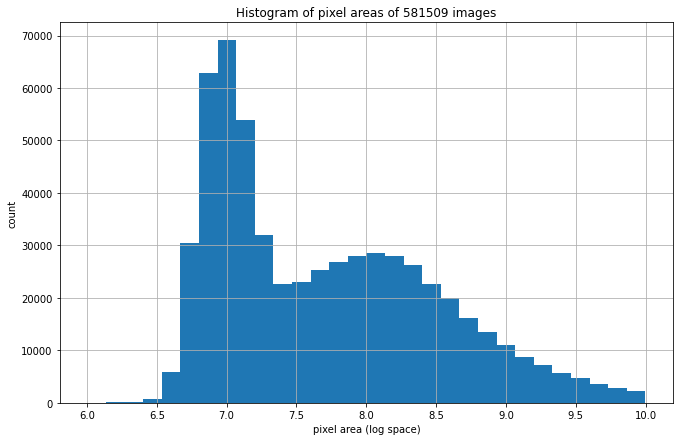

In [ ]:
plt.figure(figsize=[11,7])
plt.grid()
h = plt.hist(np.log(a), bins=30)
plt.xlabel("pixel area (log space)")
plt.ylabel("count")
plt.title("Histogram of pixel areas of 581509 images")
plt.show()

In [ ]:
np.log(max(a))

9.999797232673536

In [ ]:
np.log(min(a))

6.003887067106539

In [ ]:
total_num_of_images = 0
for subdir, dirs, files in os.walk('../new_train_images_2'):
  print(subdir,"len:",len(files))
  total_num_of_images+=len(files)
print(total_num_of_images)

../new_train_images_2 len: 0
../new_train_images_2/11 len: 72
../new_train_images_2/12 len: 359
../new_train_images_2/13 len: 507
../new_train_images_2/15 len: 69
../new_train_images_2/17 len: 2932
../new_train_images_2/18 len: 210497
../new_train_images_2/19 len: 6892
../new_train_images_2/20 len: 1096
../new_train_images_2/21 len: 3598
../new_train_images_2/23 len: 12088
../new_train_images_2/24 len: 5852
../new_train_images_2/25 len: 3591
../new_train_images_2/26 len: 856
../new_train_images_2/27 len: 4057
../new_train_images_2/28 len: 887
../new_train_images_2/29 len: 147
../new_train_images_2/32 len: 174
../new_train_images_2/33 len: 17
../new_train_images_2/34 len: 1596
../new_train_images_2/35 len: 1820
../new_train_images_2/36 len: 124
../new_train_images_2/37 len: 120
../new_train_images_2/38 len: 121
../new_train_images_2/40 len: 569
../new_train_images_2/41 len: 1455
../new_train_images_2/42 len: 692
../new_train_images_2/44 len: 218
../new_train_images_2/45 len: 150
../new_

In [ ]:
len(list(unique.astype('int64')))

62

In [ ]:
!mkdir ../backup_new_train_images_2/

In [ ]:
!cp -r ../new_train_images_2/ ../backup_new_train_images_2/

In [ ]:
!rm -r ../backup_new_train_images_2/

^C


In [ ]:
!mkdir ../new_train_images_2

mkdir: cannot create directory ‘../new_train_images_2’: File exists


In [ ]:
for i in list(unique.astype('int64')):
  os.mkdir('../new_train_images_2/'+str(i))

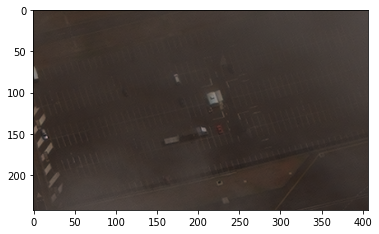

In [ ]:
plt.imshow(extracted_images[21][1])

In [ ]:
[extracted_images[i][1].shape for i in range(len(extracted_images))]

In [ ]:
im = Image.fromarray(extracted_images[44][1])
im.save("demo.jpg")

'Small Car'

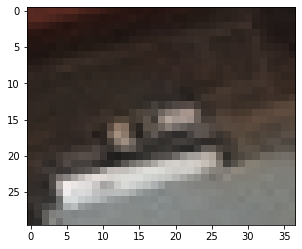

In [ ]:
plt.imshow(extracted_images[8][1])
extracted_images[8][0]

In [ ]:
#Load the class number -> class string label map
labels = {}
with open('xview_class_labels.txt') as f:
    for row in csv.reader(f):
        labels[int(row[0].split(":")[0])] = row[0].split(":")[1]

In [ ]:
labels[12]

'Small Aircraft'

In [4]:
import requests 
train_data_url = "https://d307kc0mrhucc3.cloudfront.net/train_images.tgz?Expires=1613610133&Signature=RXMiTYa4KDt4CA5lBnvzfGbzla9QZ-R2HWMOXXc7IZUJDRB1dM2GJ7nvH7VmrTSEpgLaCItP9rIujcmz2sVlmBIQLeSwNbMZElXBowY~LYFun2MXcI9DbLGNb9cCgoZakb4TV1nShNxk0a0VVIOGrGBSrC3HRxThwpFiVwvmtoizlKUtdR9WBAl7dMPrz4EzMFDoyEMsDPgX~7IkCO0Rq6b8ZqhVG1IpF7w0AK4zOSgAtdGQw6cnO9bWIMmFsTn5HHcmQHBZPVnxM~~Vd46rNFVO0vtJkAnI7axYuS0DG7h7CZgvNYs8gWg6K5-2QLc32BsrNq~zHn3CZ0U2cfI5QQ__&Key-Pair-Id=APKAIKGDJB5C3XUL2DXQ"
train_label_url = "https://d307kc0mrhucc3.cloudfront.net/train_labels.tgz?Expires=1613610133&Signature=LApkZrOoj6biVxVQUw7fQUABoqu91SXR0f8WknFi~2claRwDQnt3UVl2m9DBG1lbCrKzm~mpgXE-JrbLKAO584C2gl5KtzQyUrbmd2OZlF8JPZnUo7jjRNc7X8xHA0fd01KGZrv0G30Wm-H2stTWTekxikdSMupe6R07Xrjan-c3Rpm9-qTYCURjDrIYQkNrsdVHkGbX7bain87t9rd1NUT-y~vRRUbrMMTvaRpr2GfAeWXcA4CoW0ocSknZgwOWG9xzSGCPUI2w9iEIdP9KxnRgj~iz9vx7vjlVVTuZawJ8GVRwiKJMLUrxp1kryWaKeqjerOsF1U3IMCHlVSyrEA__&Key-Pair-Id=APKAIKGDJB5C3XUL2DXQ"
val_data_url = "https://d307kc0mrhucc3.cloudfront.net/val_images.tgz?Expires=1613610133&Signature=LajBHSDJtytUmYt2ZDgPP9fPBPw~weaCoLNd62FQ8a05tnTiFnCbdYQuFvAF-bZD0qyiaSSHHsWxA5PxpqDyknlWi8x0Tthlf34k7tVZejJOHJTQnbvWIsMjnBAdxVwRbtvg3YZe9kXHpiaRWkGqX7p30dQuTaeAbGed4Zbf82Gk2Uv0IIzWFBRb4WHI9X-jlaV6068NxXF-2N1ihiO7UTgiz-Hp3e~n2GBtCnN-fwY2zeRf5~6WTR2vLPot~c95ktpAEvRljke6JekyppqOXvdeLDScEX5qvC9M99wE8RuTlC71Qd3y4yBXKShNB-3R85wBJU-AqVRh7VVK0fLckQ__&Key-Pair-Id=APKAIKGDJB5C3XUL2DXQ"

file_names = ["train_images"]
data_urls = [train_data_url]
file_url = zip(file_names,data_urls)

for file_name, data_url in file_url:
  r = requests.get(data_url, stream = True) 
  with open(work_dir+data_dir+file_name+'.tgz', "wb") as file: 
    for block in r.iter_content(chunk_size = 1024): 
      if block: 
        file.write(block) 

In [ ]:
train_data_url = "https://d307kc0mrhucc3.cloudfront.net/train_images.tgz?Expires=1613610133&Signature=RXMiTYa4KDt4CA5lBnvzfGbzla9QZ-R2HWMOXXc7IZUJDRB1dM2GJ7nvH7VmrTSEpgLaCItP9rIujcmz2sVlmBIQLeSwNbMZElXBowY~LYFun2MXcI9DbLGNb9cCgoZakb4TV1nShNxk0a0VVIOGrGBSrC3HRxThwpFiVwvmtoizlKUtdR9WBAl7dMPrz4EzMFDoyEMsDPgX~7IkCO0Rq6b8ZqhVG1IpF7w0AK4zOSgAtdGQw6cnO9bWIMmFsTn5HHcmQHBZPVnxM~~Vd46rNFVO0vtJkAnI7axYuS0DG7h7CZgvNYs8gWg6K5-2QLc32BsrNq~zHn3CZ0U2cfI5QQ__&Key-Pair-Id=APKAIKGDJB5C3XUL2DXQ"
train_label_url = "https://d307kc0mrhucc3.cloudfront.net/train_labels.tgz?Expires=1613610133&Signature=LApkZrOoj6biVxVQUw7fQUABoqu91SXR0f8WknFi~2claRwDQnt3UVl2m9DBG1lbCrKzm~mpgXE-JrbLKAO584C2gl5KtzQyUrbmd2OZlF8JPZnUo7jjRNc7X8xHA0fd01KGZrv0G30Wm-H2stTWTekxikdSMupe6R07Xrjan-c3Rpm9-qTYCURjDrIYQkNrsdVHkGbX7bain87t9rd1NUT-y~vRRUbrMMTvaRpr2GfAeWXcA4CoW0ocSknZgwOWG9xzSGCPUI2w9iEIdP9KxnRgj~iz9vx7vjlVVTuZawJ8GVRwiKJMLUrxp1kryWaKeqjerOsF1U3IMCHlVSyrEA__&Key-Pair-Id=APKAIKGDJB5C3XUL2DXQ"
val_data_url = "https://d307kc0mrhucc3.cloudfront.net/val_images.tgz?Expires=1613610133&Signature=LajBHSDJtytUmYt2ZDgPP9fPBPw~weaCoLNd62FQ8a05tnTiFnCbdYQuFvAF-bZD0qyiaSSHHsWxA5PxpqDyknlWi8x0Tthlf34k7tVZejJOHJTQnbvWIsMjnBAdxVwRbtvg3YZe9kXHpiaRWkGqX7p30dQuTaeAbGed4Zbf82Gk2Uv0IIzWFBRb4WHI9X-jlaV6068NxXF-2N1ihiO7UTgiz-Hp3e~n2GBtCnN-fwY2zeRf5~6WTR2vLPot~c95ktpAEvRljke6JekyppqOXvdeLDScEX5qvC9M99wE8RuTlC71Qd3y4yBXKShNB-3R85wBJU-AqVRh7VVK0fLckQ__&Key-Pair-Id=APKAIKGDJB5C3XUL2DXQ"
folder_names = ["train_images", "train_labels",'val_images']
data_urls = [train_data_url, train_label_url, val_data_url]
folder_url = zip(folder_names,data_urls)
for i,h in folder_url:
  print(i,h)

train_images https://d307kc0mrhucc3.cloudfront.net/train_images.tgz?Expires=1613610133&Signature=RXMiTYa4KDt4CA5lBnvzfGbzla9QZ-R2HWMOXXc7IZUJDRB1dM2GJ7nvH7VmrTSEpgLaCItP9rIujcmz2sVlmBIQLeSwNbMZElXBowY~LYFun2MXcI9DbLGNb9cCgoZakb4TV1nShNxk0a0VVIOGrGBSrC3HRxThwpFiVwvmtoizlKUtdR9WBAl7dMPrz4EzMFDoyEMsDPgX~7IkCO0Rq6b8ZqhVG1IpF7w0AK4zOSgAtdGQw6cnO9bWIMmFsTn5HHcmQHBZPVnxM~~Vd46rNFVO0vtJkAnI7axYuS0DG7h7CZgvNYs8gWg6K5-2QLc32BsrNq~zHn3CZ0U2cfI5QQ__&Key-Pair-Id=APKAIKGDJB5C3XUL2DXQ
train_labels https://d307kc0mrhucc3.cloudfront.net/train_labels.tgz?Expires=1613610133&Signature=LApkZrOoj6biVxVQUw7fQUABoqu91SXR0f8WknFi~2claRwDQnt3UVl2m9DBG1lbCrKzm~mpgXE-JrbLKAO584C2gl5KtzQyUrbmd2OZlF8JPZnUo7jjRNc7X8xHA0fd01KGZrv0G30Wm-H2stTWTekxikdSMupe6R07Xrjan-c3Rpm9-qTYCURjDrIYQkNrsdVHkGbX7bain87t9rd1NUT-y~vRRUbrMMTvaRpr2GfAeWXcA4CoW0ocSknZgwOWG9xzSGCPUI2w9iEIdP9KxnRgj~iz9vx7vjlVVTuZawJ8GVRwiKJMLUrxp1kryWaKeqjerOsF1U3IMCHlVSyrEA__&Key-Pair-Id=APKAIKGDJB5C3XUL2DXQ
val_images https://d307kc0mrhucc3.cloudfront.net/v